##**Imports**

In [168]:
!pip install -Uqq ipdb
import ipdb
%pdb off

Automatic pdb calling has been turned OFF


In [202]:
from tensorflow.keras.applications import ResNet50
resnet50_model = ResNet50(weights='imagenet')
resnet50_model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [115]:
# !pip install mlflow --quiet

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import cv2
import math
# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import load_model

In [117]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Utility Functions**

In [118]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    MAX_FILE_COUNT = 250
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    # file_list.count
    cnt = 0
    for file in file_list:
        cnt += 1
        if cnt > MAX_FILE_COUNT: #Stop creating files in the local directory if the number of files > MAX_FILE_COUNT
          break
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass

def create_base_model(activation, initializer, regularizer, dropout_rate, num_start_cnn_neurons=32, num_dense_neurons=256):
    model = tf.keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*2, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*4, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

def create_restnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons=256):
    restnet_cnn_layers = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet',
                                                )

    last_conv_layer = restnet_cnn_layers.get_layer('conv5_block3_out')
    # Convolutional part from the resnet model
    conv_layers = Model(inputs=restnet_cnn_layers.input, outputs=last_conv_layer.output)
    # Freeze all conv layers
    conv_layers.trainable = False

    # Start a new Keras Sequential model.
    model = tf.keras.Sequential()

    model.add(layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    # Add only the convolutional part of the RestNet50 model from above.
    model.add(conv_layers)

    # the resnet model uses a global average pooling layer before the final dense layer
    # other models may just flatten the final convolutional layer or
    # use other pooling layers so make sure to check the original model architecture
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Adding one Dense layer before the final output layer
    model.add(tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Add a final dense (aka. fully-connected) layer.
    # This is for combining features recognized in the image and calculating predictions
    # note that the number of nodes is the sameas the number of classes
    model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax'))

    return model

def get_mismatches(y_true, y_pred, BATCH_SIZE):
    num_mismatches = 0
    mismatch_tensor_indexes = {}
    for i in range(len(y_true)):
      if y_true[i] != y_pred[i]:
        num_mismatches += 1
        key = (i//BATCH_SIZE)
        tensor_index = (i % BATCH_SIZE)
        if mismatch_tensor_indexes.get(key) is not None:
          mismatch_tensor_indexes[key].append((tensor_index, i))
        else:
          mismatch_tensor_indexes[key] = [(tensor_index, i)]
    return num_mismatches, mismatch_tensor_indexes

def show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches):
    i=0
    total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
    tensor_batch = 0
    plt.figure(figsize=(15, (math.ceil(num_mismatches/30)*20)))
    for images, labels in test_ds.take(total_tensor_batches):
      if mismatch_tensor_indexes.get(tensor_batch) is not None:
        for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
          ax = plt.subplot(math.ceil(num_mismatches/4), 4, i + 1)
          plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1
      tensor_batch += 1


In [119]:
math.ceil(26/30)

1

## **Load images and models in current session's workspace**


In [120]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
# processed_datasets_folder_id = '1DZUC9VVBQ24xNsgFj-snz3ocRdmI-0xv'
# bags_folder_id = ''
# schuhe_folder_id = ''
# waesche_folder_id = ''

# root = './data/processed/bag'

# if not os.path.isdir("./data"):
#   os.mkdir('./data')

# if not os.path.isdir("./data/processed"):
#   os.mkdir('./data/processed')

# if not os.path.isdir("./data/processed/bag"):
#   os.mkdir('./data/processed/bag')

# search_processed_datasets_folder(processed_datasets_folder_id, root)
# f.close()

model_folder_id = '1JUgLVKtQinZkC79GIsnu6YwbAESWpntX'

# Note: these folders should match the final project folder structure we create and may need to be updated

model_root = './models'

if not os.path.isdir("./models"):
  os.mkdir('./models')


search_folder(model_folder_id, model_root+'/')  # search_folder(folder_id,root+'/')
f.close()

In [121]:
f = open("failed.txt","w+")
processed_datasets_folder_id = '1wh7Efgtn3Jeu5Ox6Xw-fNfHAmDYRTyTC' # '1DZUC9VVBQ24xNsgFj-snz3ocRdmI-0xv'

root = './data/processed/waesche'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

if not os.path.isdir("./data/processed/waesche"):
  os.mkdir('./data/processed/waesche')

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()


In [122]:
PRODUCT_CATEGORY = 'waesche' # 'bag' # 'clothes'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above

# CLASSES = ['clothes_0_model_front'
#            , 'clothes_1_zoomed'
#            , 'clothes_2_model_back'
#            , 'clothes_3_ghost'
#            , 'clothes_4_look'
#            ]

# CLASSES = ['bag_0_front'
#            , 'bag_1_side'
#            , 'bag_2_inside'
#            , 'bag_3_back'
#            , 'bag_4_look'
#            ]

CLASSES = ['waesche_0_model_front'
           , 'waesche_1_zoomed'
           , 'waesche_2_model_back'
           , 'waesche_3_ghost'
           , 'waesche_4_look'
           ]

train_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')

In [123]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
waesche_0_model_front occurs 155 times
waesche_1_zoomed occurs 166 times
waesche_2_model_back occurs 154 times
waesche_3_ghost occurs 159 times
waesche_4_look occurs 134 times


In [124]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
waesche_0_model_front occurs 44 times
waesche_1_zoomed occurs 44 times
waesche_2_model_back occurs 54 times
waesche_3_ghost occurs 45 times
waesche_4_look occurs 69 times


In [125]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
waesche_0_model_front occurs 49 times
waesche_1_zoomed occurs 35 times
waesche_2_model_back occurs 46 times
waesche_3_ghost occurs 45 times
waesche_4_look occurs 51 times


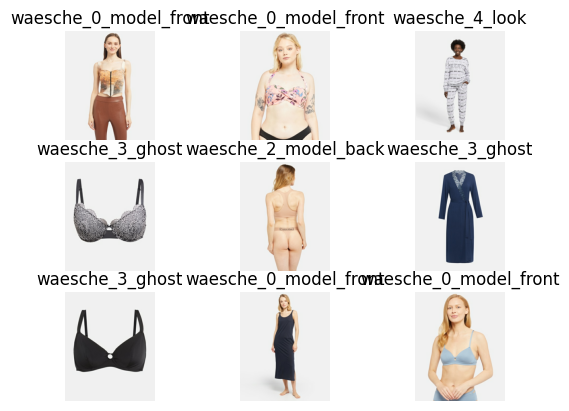

In [126]:
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")


##**Defining the GradCAM Class**

In [184]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):

        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):

        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, verbose=False):

        # Step 1:
        # construct our gradient model by supplying
        # (1) the inputs to our pre-trained model
        # (2) the output of the (presumably) final 4D layer in the network
        # (3) the output of the softmax activations from the model

        # ipdb.set_trace() # for debugging

        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        if verbose:
            print('\nStep 1:')
            print('Model:', self.model.name)
            print('Conv layerName:', self.layerName)
            print('Conv Layer Shape:', gradModel.outputs[0].shape)


        # Step 2:
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:

            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        if verbose:
            print('\nStep 2:')
            print('loss:', loss)
            print('convOutputs shape;', convOutputs.shape)
            print('gradients shape:', grads.shape)


        # Step 3:
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        if verbose:
            print('\nStep 3')
            print('guidedGrads shape', guidedGrads.shape)

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        if verbose:
            print('guidedGrads shape batch removal', guidedGrads.shape)
            print('convOutputs shape batch removal', convOutputs.shape)


        # Step 4:
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        if verbose:
            print('\nStep 4:')
            print('weights shape:', weights.shape)
            print('cam shape:', cam.shape)


        # Step 5:
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h),
                            interpolation=cv2.INTER_CUBIC)

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        if verbose:
            print('\nStep 5:')
            print('heatmap shape:', heatmap.shape)

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_JET):

        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

# **Applying GradCAM**

####Load model

In [185]:
# model = load_model('/content/models/model_cnn_base_waesche_88%.h5')
model = load_model('/content/models/model_resnet_finetuned_waesch_92%.h5')

model.summary()


# ------------------------------- Orig_Live Coding:

# vgg_model = VGG16(weights='imagenet')
# vgg_pre_process_fn = tf.keras.applications.vgg16.preprocess_input

# resnet50_model = ResNet50(weights='imagenet')
# resnet50_pre_process_fn = tf.keras.applications.resnet50.preprocess_input

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 427, 350, 3)       0         
                                                                 
 model (Functional)          (None, 14, 11, 2048)      23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 14963717 (57.08 MB)
Non-trainable params: 8634240 (32.94 MB)
_________________________________________________________________


In [201]:
model_2 = Sequential()

model_2.add(model.get_layer('lambda_1'))

for l in model.get_layer('model').layers:
  model_2.add(l)

model_2.add('global_average_pooling2d_1')

model_2.add('dense_1')

ValueError: Exception encountered when calling layer "conv2_block1_add" (type Add).

A merge layer should be called on a list of inputs. Received: inputs=Tensor("Placeholder:0", shape=(None, 107, 88, 256), dtype=float32) (not a list of tensors)

Call arguments received by layer "conv2_block1_add" (type Add):
  • inputs=tf.Tensor(shape=(None, 107, 88, 256), dtype=float32)

## Helper Functions - Image Utilities

In [187]:
# helper function for image pre-processing
def image_processing_function(im_path, input_img_dims, pre_process_function=None):
  # load the original image from gdrive (in OpenCV format)
  # resize the image to its target dimensions

  if type(im_path) == str:
    # orig = cv2.imread(im_path)
    # orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig = load_img(im_path)
    orig_arr = img_to_array(orig).astype("uint8")

    # load the input image from gdrive (in Keras/TensorFlow format)
    # basic image pre-processing

    image = load_img(im_path, target_size=input_img_dims)

  else:
    orig = im_path
    orig_arr = img_to_array(orig).astype("uint8")

    image = im_path

  image_arr = img_to_array(image)
  image_arr = np.expand_dims(image_arr, axis=0)
  if pre_process_function:
    image_arr = pre_process_function(image_arr)

  return image_arr, orig_arr


# helper function to get predicted classes
# def get_class_predictions(preds, class_rank):
#   rank = class_rank
#   classes_ranked = np.argsort(preds[0])[::-1]
#   i = classes_ranked[rank]

#   decoded = imagenet_utils.decode_predictions(preds, 10)
#   (imagenetID, label, prob) = decoded[0][0]

#   label = "{}: {:.2f}%".format(label, prob * 100)
#   print('Class with highest probability:')
#   print("{}".format(label))

#   return i, decoded

## Load and Pre-process Image

#### In case we have one image to read and its path:

In [188]:
# define path to image

try:
  # im_path = '/content/32938725-001.jpg'
  im_path = '/content/32891827-001.jpg'

  # use helper function for image pre-processing
  image_size=(IMG_HEIGHT, IMG_WIDTH)
  input_img_dims = image_size
  image, orig = image_processing_function(im_path, input_img_dims) # , vgg_pre_process_fn
except:
  pass

In [189]:
for img in test_ds.take(1):
  orig = img[0][0]

In [190]:
orig.shape

TensorShape([427, 350, 3])

In [191]:
orig_np = orig.numpy().astype('uint8')

# orig_np

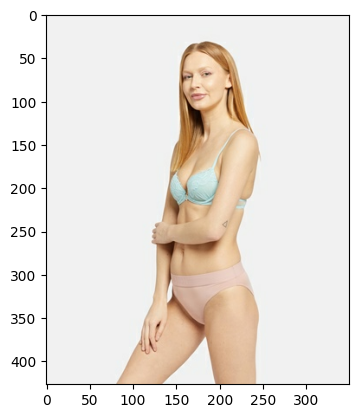

In [192]:
plt.imshow(orig_np)

In [193]:
image_size=(IMG_HEIGHT, IMG_WIDTH)
input_img_dims = image_size
image, orig = image_processing_function(orig, input_img_dims) # , vgg_pre_process_fn

## Run model Inference

In [194]:
# use the network to make predictions on the input image and find
preds = model.predict(image)

preds

1/1 [==============================] - 1s 1000ms/step


array([[4.6724925e-04, 8.0204109e-06, 1.0799053e-04, 1.4642775e-02,
        9.8477399e-01]], dtype=float32)

In [195]:
pred_class = np.argmax(preds)
pred_class_name = CLASSES[pred_class]

print(f"{pred_class = }")
print(f"{pred_class_name = }")

pred_class = 4
pred_class_name = 'waesche_4_look'


## Initialize GradCAM instance

In [196]:
model_gc = GradCAM(model=model, classIdx=pred_class, layerName='conv5_block3_out')

In [197]:
model_gc.layerName

'conv5_block3_out'

## Get GradCAM heatmap

In [198]:
heatmap = model_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = model_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 427, 350, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [ ]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off');
ax[0].imshow(orig);
ax[1].imshow(heatmap)
ax[2].imshow(output);
[axi.set_axis_off() for axi in ax.ravel()];

# function

#### In case we read the input images from the (test)dataset:

In [ ]:
def draw_gradCam_heatmap(img, model):
  '''
  img: either the path to the image or one loaded image.
  '''

  # use the network to make predictions on the input image and find
  preds = model.predict(image)
  pred_class = np.argmax(preds)

  model_gc = GradCAM(model=model, classIdx=pred_class)

  heatmap = model_gc.compute_heatmap(image, verbose=True)
  # resize the resulting heatmap to the original input image dimensions
  # overlay heatmap on top of the image
  heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
  (heatmap, output) = model_gc.overlay_heatmap(heatmap, orig, alpha=0.35)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
  output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

  fig, ax = plt.subplots(1,3, figsize=(20, 10))
  plt.axis('off');
  ax[0].imshow(orig); ax[0].text(5, 10, f'{pred_class_name = }', bbox={'facecolor': 'white', 'pad': 2})
  im = ax[1].imshow(heatmap); fig.colorbar(im, ax=ax[1], fraction=0.055); # ax[1].colorbar(im, fraction=0.046, pad=0.04)
  ax[2].imshow(output);
  [axi.set_axis_off() for axi in ax.ravel()];


In [ ]:
for img in test_ds.take(5): # If needed, list of the misclassified images could be also given instead of the test_ds
  orig = img[0][0]
  image, orig = image_processing_function(orig, input_img_dims)

  draw_gradCam_heatmap(orig, model)